<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52177 entries, 0 to 52176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eiaid         52177 non-null  int64  
 1   utility_name  52177 non-null  int32  
 2   state         52177 non-null  int32  
 3   service_type  52177 non-null  int32  
 4   ownership     52177 non-null  int32  
 5   comm_rate     52177 non-null  float64
 6   ind_rate      52177 non-null  float64
 7   res_rate      52177 non-null  float64
dtypes: float64(3), int32(4), int64(1)
memory usage: 2.4 MB


C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


              precision    recall  f1-score   support

           0       1.00      0.54      0.70      3408
           1       0.82      1.00      0.90      7028

    accuracy                           0.85     10436
   macro avg       0.91      0.77      0.80     10436
weighted avg       0.88      0.85      0.83     10436

Precision: 1.0
Recall: 0.5355046948356808
F1 Score: 0.6974966558379515


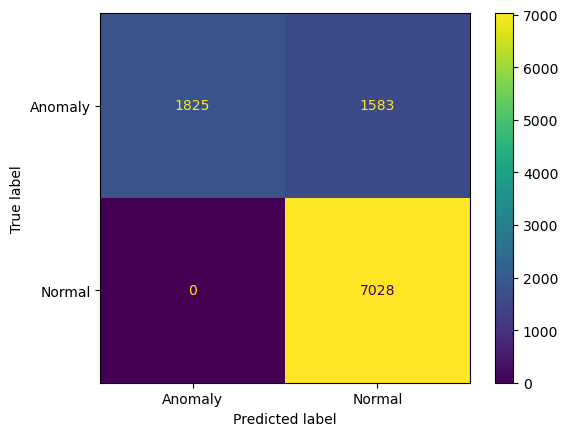

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

def hybrid_anomaly_detection():
    
    data = pd.read_csv('US_Util_2020.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
#     text_columns = data[['service_type','ownership','state']]
   

#     # Assuming 'text_columns' is a list of columns containing text values
#     label_encoder = LabelEncoder()
#     for col in text_columns:
#         data[col + '_encoded'] = label_encoder.fit_transform(data[col])
        
#     label_encoder = LabelEncoder()
#     data['state_encoded'] = label_encoder.fit_transform(data['state'])
#     data['service_type_encoded'] = label_encoder.fit_transform(data['service_type'])
#     data['ownership_encoded'] = label_encoder.fit_transform(data['ownership'])
    
    
    data = data.drop(['zip'], axis=1)
    
    
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    data.info()
    X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['res_rate']
    
    data = data.dropna(axis=0, inplace=True)
#     #convert all the values in the columns into numeric
#     for column in data.columns:
#         data[column] = pd.to_numeric(data[column], errors='coerce')

    y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
    
    selector = SelectKBest(f_classif, k=5)
    X_selected = selector.fit_transform(X, y)
    
    X_selected

    
    
    
    
    
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    
    # Phase 1: Train Isolation Forest on the training data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train)
    # Predict on the training data to filter for normal data only
    train_preds = iso_forest.predict(X_train)

    # Filter normal data as input for the SVM
    X_train_filtered = X_train[train_preds == 1]
    y_train_filtered = y_train[train_preds == 1]

    # Phase 2: Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_filtered, y_train_filtered)

    # Evaluate on the original full test dataset
    svm_predictions = svm.predict(X_test)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, svm_predictions, pos_label=0)
    recall = recall_score(y_test, svm_predictions, pos_label=0)
    f1 = f1_score(y_test, svm_predictions, pos_label=0)

    # Print metrics
    
    print(classification_report(y_test, svm_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Assuming X and y are your dataset's features and labels respectively
hybrid_anomaly_detection()
